# Monk1 
Grid Search for Monk1 dataset model selection


In [169]:
from exclusiveAI.components.Validation.HoldOut import parallel_hold_out, hold_out
from exclusiveAI.ConfiguratorGen import ConfiguratorGen
from exclusiveAI.datasets.monk import read_monk1
from exclusiveAI.utils import one_hot_encoding
from exclusiveAI.Composer import Composer
from tqdm import tqdm
import pandas as pd
import numpy as np
from exclusiveAI.utils import plot_history
import os, json

#### Read Monk1 dataset 

In [170]:
training_data, training_labels, test_data, test_labels = read_monk1("../exclusiveAI/datasets/")

One-Hot Encoding Training Dataset

In [171]:
training_data = one_hot_encoding(training_data)

One-Hot Encoding Test Dataset

In [172]:
test_data = one_hot_encoding(test_data)

Getting the (most interesting) models from the big grid search 

In [173]:
def read_json_files(my_dir_path):
        data = pd.DataFrame()
        for file in os.listdir(my_dir_path):
            if file.endswith('.json'):
                with open(os.path.join(my_dir_path, file), 'r') as f:
                    my_data = [data['0'] for data in json.load(f).values()]
                    data = pd.concat([data,  pd.DataFrame(my_data)], ignore_index=True, axis=0)
        return data
batch_size = 32
epochs = 500

if not os.path.exists('monk1_models_configs.json'):
    dir_path = "Monk1/"
    
    all_json_data = read_json_files(dir_path)
    regularizations = all_json_data['regularization'].unique().tolist()
    regularizations.insert(0, 1e-7)
    learning_rates = all_json_data['learning_rate'].unique().tolist()
    learning_rates.insert(0, 0.5)
    momentums = all_json_data['momentum'].unique().tolist()
    momentums = set([value if value>0.89 else 0.4 for value in momentums])
    num_of_layers = all_json_data['num_layers'].unique().tolist()
    num_of_units = set([unit1 for unit in all_json_data['num_of_units'] for unit1 in unit])
    initializers = ["uniform", "gaussian"]
    activations = ["sigmoid"]
    
    myConfigurator = ConfiguratorGen(random=False, learning_rates=learning_rates, regularizations=regularizations,
                                     loss_function=['mse'], optimizer=['sgd'],
                                     activation_functions=activations,
                                     number_of_units=num_of_units, number_of_layers=num_of_layers,
                                     momentums=momentums, initializers=initializers,
                                     input_shapes=training_data.shape,
                                     verbose=False, nesterov=True, 
                                     callbacks=["earlystopping"], output_activation='sigmoid', show_line=False,
                                     ).get_configs()
    len(myConfigurator)
    
    configs=[]
    if __name__ == '__main__':
        configs.append(
            parallel_hold_out(myConfigurator, training=training_data, training_target=training_labels, epochs=epochs,
                              batch_size=batch_size, num_models=100, workers=8, number_of_initializations=3, return_models_history=True,
                              ))
    
        configs = pd.DataFrame(configs)
        # Save as json
        configs.to_json('monk1_models_configs.json')
else: 
    with open('monk1_models_configs.json', 'r') as f:
        configs = [data['0'] for data in json.load(f).values()]

In [174]:
models = []
old_histories = configs[0]
configs=configs[1]
with tqdm(total=len(configs)) as pbar:
    for old_hist, config in zip(old_histories, configs):
        model = Composer(config=config).compose()
        model.train(inputs=training_data, input_label=training_labels, epochs=epochs, batch_size=batch_size, name=config['model_name'], disable_line=True)
        test_val = model.evaluate(input=test_data, input_label=test_labels)
        models.append((model.get_last()['mse'], np.std(np.array(model.history['mse'])), model.get_last()['binary_accuracy'], test_val[0], test_val[1], model.curr_epoch, old_hist['binary_accuracy'][-1],  old_hist['val_binary_accuracy'][-1], old_hist['mee'],  old_hist['val_mee'], model.history['mee'], Composer(config=config).compose(), config, config['num_layers'], config['num_of_units'], config['model_name']))
        pbar.update(1)

# Convert the list of tuples to a DataFrame with one column for each element in the tuple
df = pd.DataFrame(models, columns=['Score', 'History_Std', 'Accuracy', 'Test_Score', 'Test_Accuracy', 'Trained_Epochs', 'Old_Accuracy', 'Old_Accuracy_val', 'Old_History', 'Old_History_val', 'History', 'Model', 'Config', 'Num_Layers', 'Num_of_Units', 'Name'])

100%|██████████| 77/77 [00:23<00:00,  3.32it/s]


In [175]:
# Sort the DataFrame by the first element in the tuple (column 'Value')

df_sorted = df.sort_values(by=['Num_Layers', 'Score', 'Test_Score', 'History_Std'])
df_sorted = df_sorted[df_sorted['Accuracy'] >= 1]
df_sorted = df_sorted[df_sorted['Test_Accuracy'] >= 1]
# df_sorted = df_sorted[df_sorted['History_Std'] <= 0.11]
# df_sorted = df_sorted[df_sorted['Num_Layers'] <= 1]
# df_sorted['Num_of_Units'] = [value[0] for value in df_sorted['Num_of_Units']]
# df_sorted = df_sorted[df_sorted['Num_of_Units'] == 4]
histories = {row[0]: row[1] for row in df_sorted[['Name', 'History']].values}
old_histories = {row[0]: row[1] for row in df_sorted[['Name', 'Old_History']].values}
old_histories_val = {row[0]: row[1] for row in df_sorted[['Name', 'Old_History_val']].values}
df_sorted

,Score,History_Std,Accuracy,Test_Score,Test_Accuracy,Trained_Epochs,Old_Accuracy,Old_Accuracy_val,Old_History,Old_History_val,History,Model,Config,Num_Layers,Num_of_Units,Name
59,0.008743,0.062176,1.0,0.013097,1.0,500,0.878788,0.72,"[0.496979028, 0.4968110919, 0.4967552722, 0.49...","[0.4949029088, 0.4945509434, 0.4940968454, 0.4...","[0.5040142, 0.50315225, 0.5022929, 0.5015252, ...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-07, 'learning_rate': 0.5...",1,[4],Model5
41,0.013379,0.059734,1.0,0.020736,1.0,500,0.888889,0.72,"[0.4988861978, 0.498559624, 0.4982363284, 0.49...","[0.4975266159, 0.496458441, 0.4957696795, 0.49...","[0.5006476, 0.50023514, 0.49975923, 0.49928564...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.4, ...",1,[4],Model113


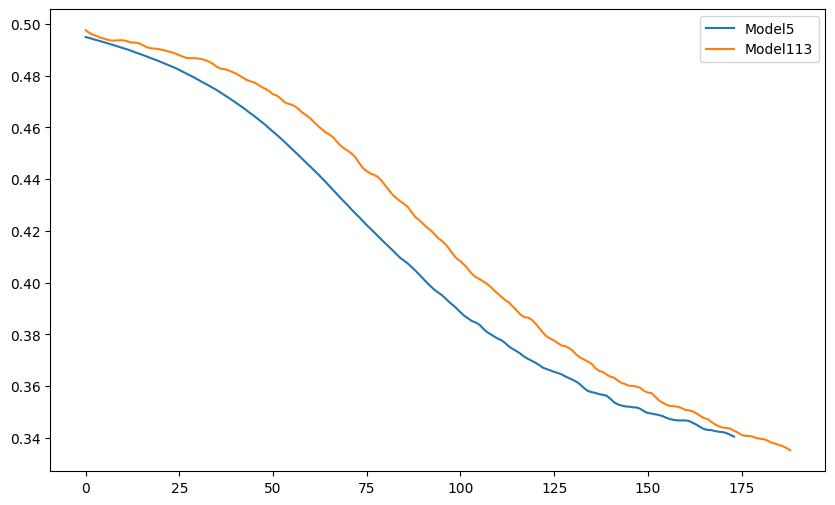

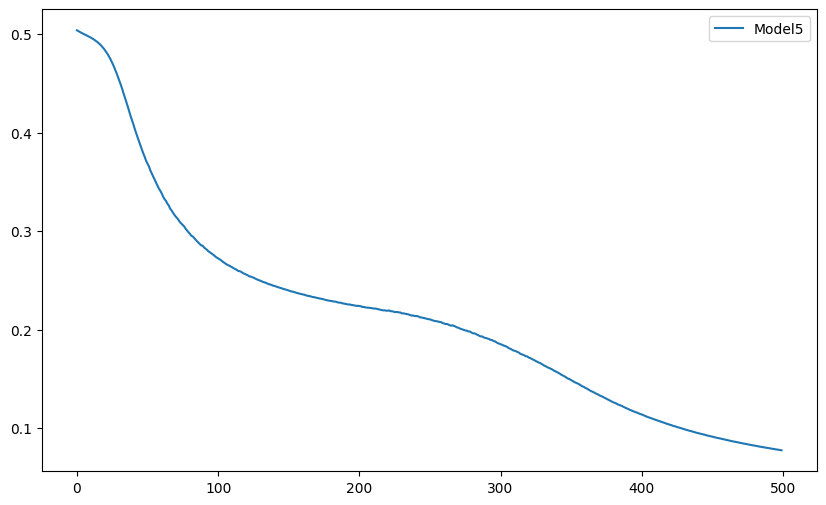

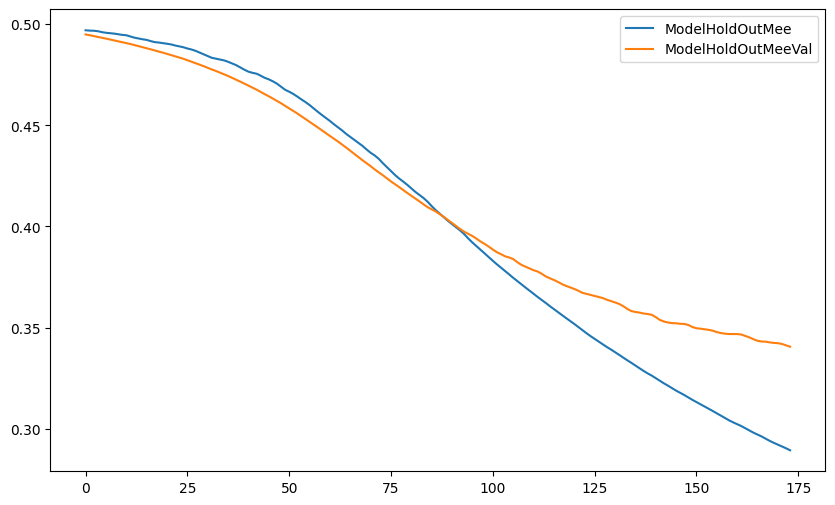

In [176]:
plot_history(old_histories_val)
plot_history({list(histories)[0]: list(histories.values())[0]})
plot_history({'ModelHoldOutMee': list(old_histories.values())[0], 'ModelHoldOutMeeVal': list(old_histories_val.values())[0]})
# plot_history({list(histories)[1]: list(histories.values())[1]})


Selected row:
Score                                                        0.008743
History_Std                                                  0.062176
Accuracy                                                          1.0
Test_Score                                                   0.013097
Test_Accuracy                                                     1.0
Trained_Epochs                                                    500
Old_Accuracy                                                 0.878788
Old_Accuracy_val                                                 0.72
Old_History         [0.496979028, 0.4968110919, 0.4967552722, 0.49...
Old_History_val     [0.4949029088, 0.4945509434, 0.4940968454, 0.4...
History             [0.5040142, 0.50315225, 0.5022929, 0.5015252, ...
Model               <exclusiveAI.components.NeuralNetwork.NeuralNe...
Config              {'regularization': 1e-07, 'learning_rate': 0.5...
Num_Layers                                                          1
Num_of

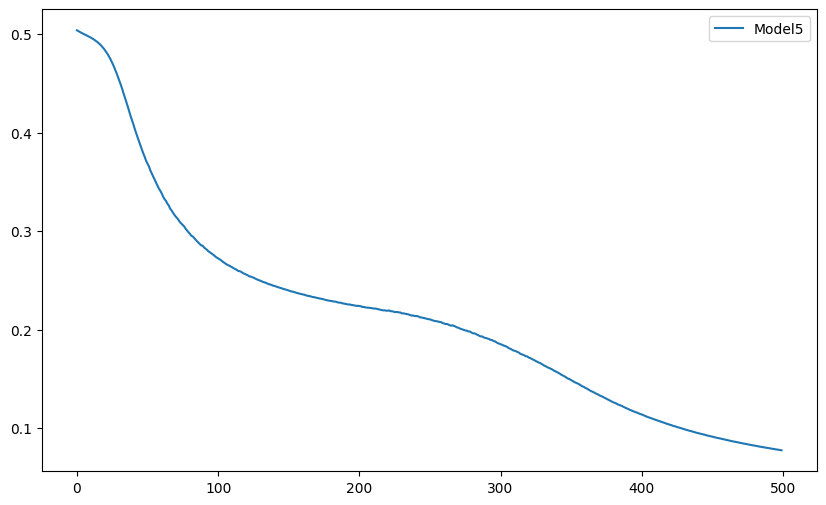

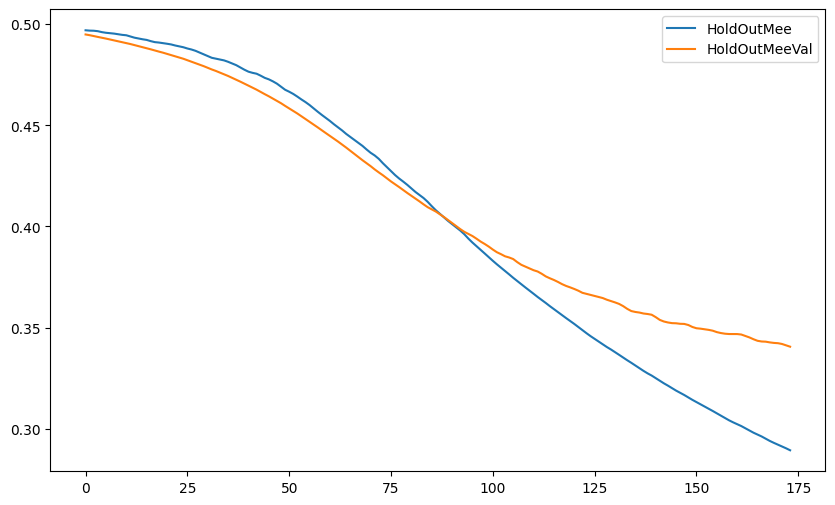

In [177]:
def find_least_difference_row(my_df):
    min_diff = float('inf')
    selected_row = None

    for index, row in my_df.iterrows():
        array = np.array(row['History'])
        differences =  (np.diff(array) / np.mean(array))
        min_consecutive_difference = np.min(differences)

        if min_consecutive_difference < min_diff:
            min_diff = min_consecutive_difference
            selected_row = row

    return selected_row

# Example usage:
result_row = find_least_difference_row(df_sorted)
print("Selected row:")
print(result_row)
plot_history({result_row["Name"]: result_row['History']})
plot_history({'HoldOutMee': result_row['Old_History'], 'HoldOutMeeVal': result_row['Old_History_val']})
